# MSG-Net

| ![msgnet.png](./images/msgnet_architecture.png) | 
|:--:| 
| *MSG-Net Architecture* |


# Imports

In [1]:
import torch
import utils.data as data
from utils.eval import compute_ssim, plot_results, calculate_fid_from_dataset, calc_content_loss, calc_style_loss
import models.MSGNet as MSGNet
import torch.optim as optim
from tqdm import trange
from torch.autograd import Variable
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.CenterCrop(size=64),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

val_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

content_trainloader, content_validloader, _, _, style_validloader, _ = data.get_dataloaders(bs=5, train_tf=train_tf, valid_tf=val_tf)


# Run model training

In [ ]:
style_model = MSGNet.Net(ngf=128)
optimizer = optim.Adam(params=style_model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

# Load pretrained vgg16
vgg = MSGNet.Vgg16()

def init_vgg16(model_folder='./models/output/MSG-Net/'):
    if not os.path.exists(os.path.join(model_folder, 'vgg16.weight')):
        if not os.path.exists(os.path.join(model_folder, 'vgg16.pth')):
            assert ValueError("Pretrained weights must be prepared, download vgg16.t7 weights and convert to vgg16.pth first")
        
        pretrained = torch.load('./models/output/MSG-Net/vgg16.pth')
        for (src, dst) in zip(list(pretrained.items()), vgg.parameters()):
            dst.data[:] = src[1]
        torch.save(vgg.state_dict(), os.path.join('./models/output/MSG-Net/', 'vgg16_msg.pth'))
        
init_vgg16()
vgg.load_state_dict(torch.load('./models/output/MSG-Net/vgg16_msg.pth'))

style_loader = data.StyleLoader()

# Helper functions
def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

def subtract_imagenet_mean_batch(batch):
    """Subtract ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size())
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch - Variable(mean.to(device))

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [ ]:
def msgnet_train(style_model, optimizer, mse_loss, vgg, content_loader, style_loader, num_epochs=2, batch_size=5, save_model_dir='./models/output/MSG-Net/'):
    style_model.to(device)
    vgg.to(device)
    tbar = trange(num_epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, x in enumerate(content_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(preprocess_batch(x))
            x = x.to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)
        
            style_v = subtract_imagenet_mean_batch(style_v)
            features_style = vgg(style_v)
            
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = subtract_imagenet_mean_batch(y)
            xc = subtract_imagenet_mean_batch(xc)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_loss = 1.0 * mse_loss(features_y[1], f_xc_c)

            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1, 1)
                style_loss += 5.0 * mse_loss(gram_y, gram_s[:n_batch, :, :])

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            # Compute quantitative results
            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % 500 == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(content_loader),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (4 * 500) == 0:
                # Save model
                style_model.eval()
                style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    1.0) + "_" + str(5.0) + ".model"
                save_model_path = os.path.join(save_model_dir, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                style_model.train()
                style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    # Compute average quantitative results
    avg_content_loss = agg_content_loss / count
    avg_style_loss = agg_style_loss / count
    
    # Save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(num_epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        1.0) + "_" + str(5.0) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)
    return avg_content_loss, avg_style_loss

In [ ]:
msg_content_loss, msg_style_loss = msgnet_train(style_model, optimizer, mse_loss, vgg, content_trainloader, style_loader, num_epochs=2)

# Run model evaluation

In [3]:
# Load chkpt model for evaluation
style_model = MSGNet.Net(ngf=128)
model_dict = torch.load('./models/output/MSG-Net/21styles.model')
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [4]:
from PIL import Image

def tensor_to_img(tensor, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    return img

def msgnet_eval(style_model, content_loader, style_loader):
    style_model.to(device)
    ssim_sum = 0.0
    fid_sum = 0.0
    running_content_loss, running_style_loss = 0.0, 0.0
    total_samples = 0
    with torch.no_grad():
        for content, style in zip(content_loader, style_loader):
            # Move content and style batches to device
            content_images = content
            content_images = content_images.to(device)
            
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            # Create stylised images
            style_v = Variable(style_images)

            content_images = Variable(content_images)
            style_model.setTarget(style_v)
            
            output = style_model(content_images)
            
            # Compute quantitative evaluation metrics
            ssim_sum += compute_ssim(content_images, output)
            fid_sum += calculate_fid_from_dataset(content_images, output, device, dims=2048)
            running_content_loss += calc_content_loss(content_images, output)
            running_style_loss += calc_style_loss(style_images, output)
            
            # Convert output to PIL Image
            stylised_images = []
            for img in output:
                img = tensor_to_img(img, cuda=True)
                stylised_images.append(img)

            # Display qualitative evaluation metrics on first batch
            if total_samples == 0:
                plot_results(content_images, style_images, style_labels, stylised_images, nrows=5, model_name="MSG-Net", msgnet=True)

            total_samples += style_labels.size(0)
            
    avg_ssim = ssim_sum / total_samples
    avg_fid = fid_sum / total_samples
    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples
    return avg_ssim, avg_fid, avg_content_loss, avg_style_loss

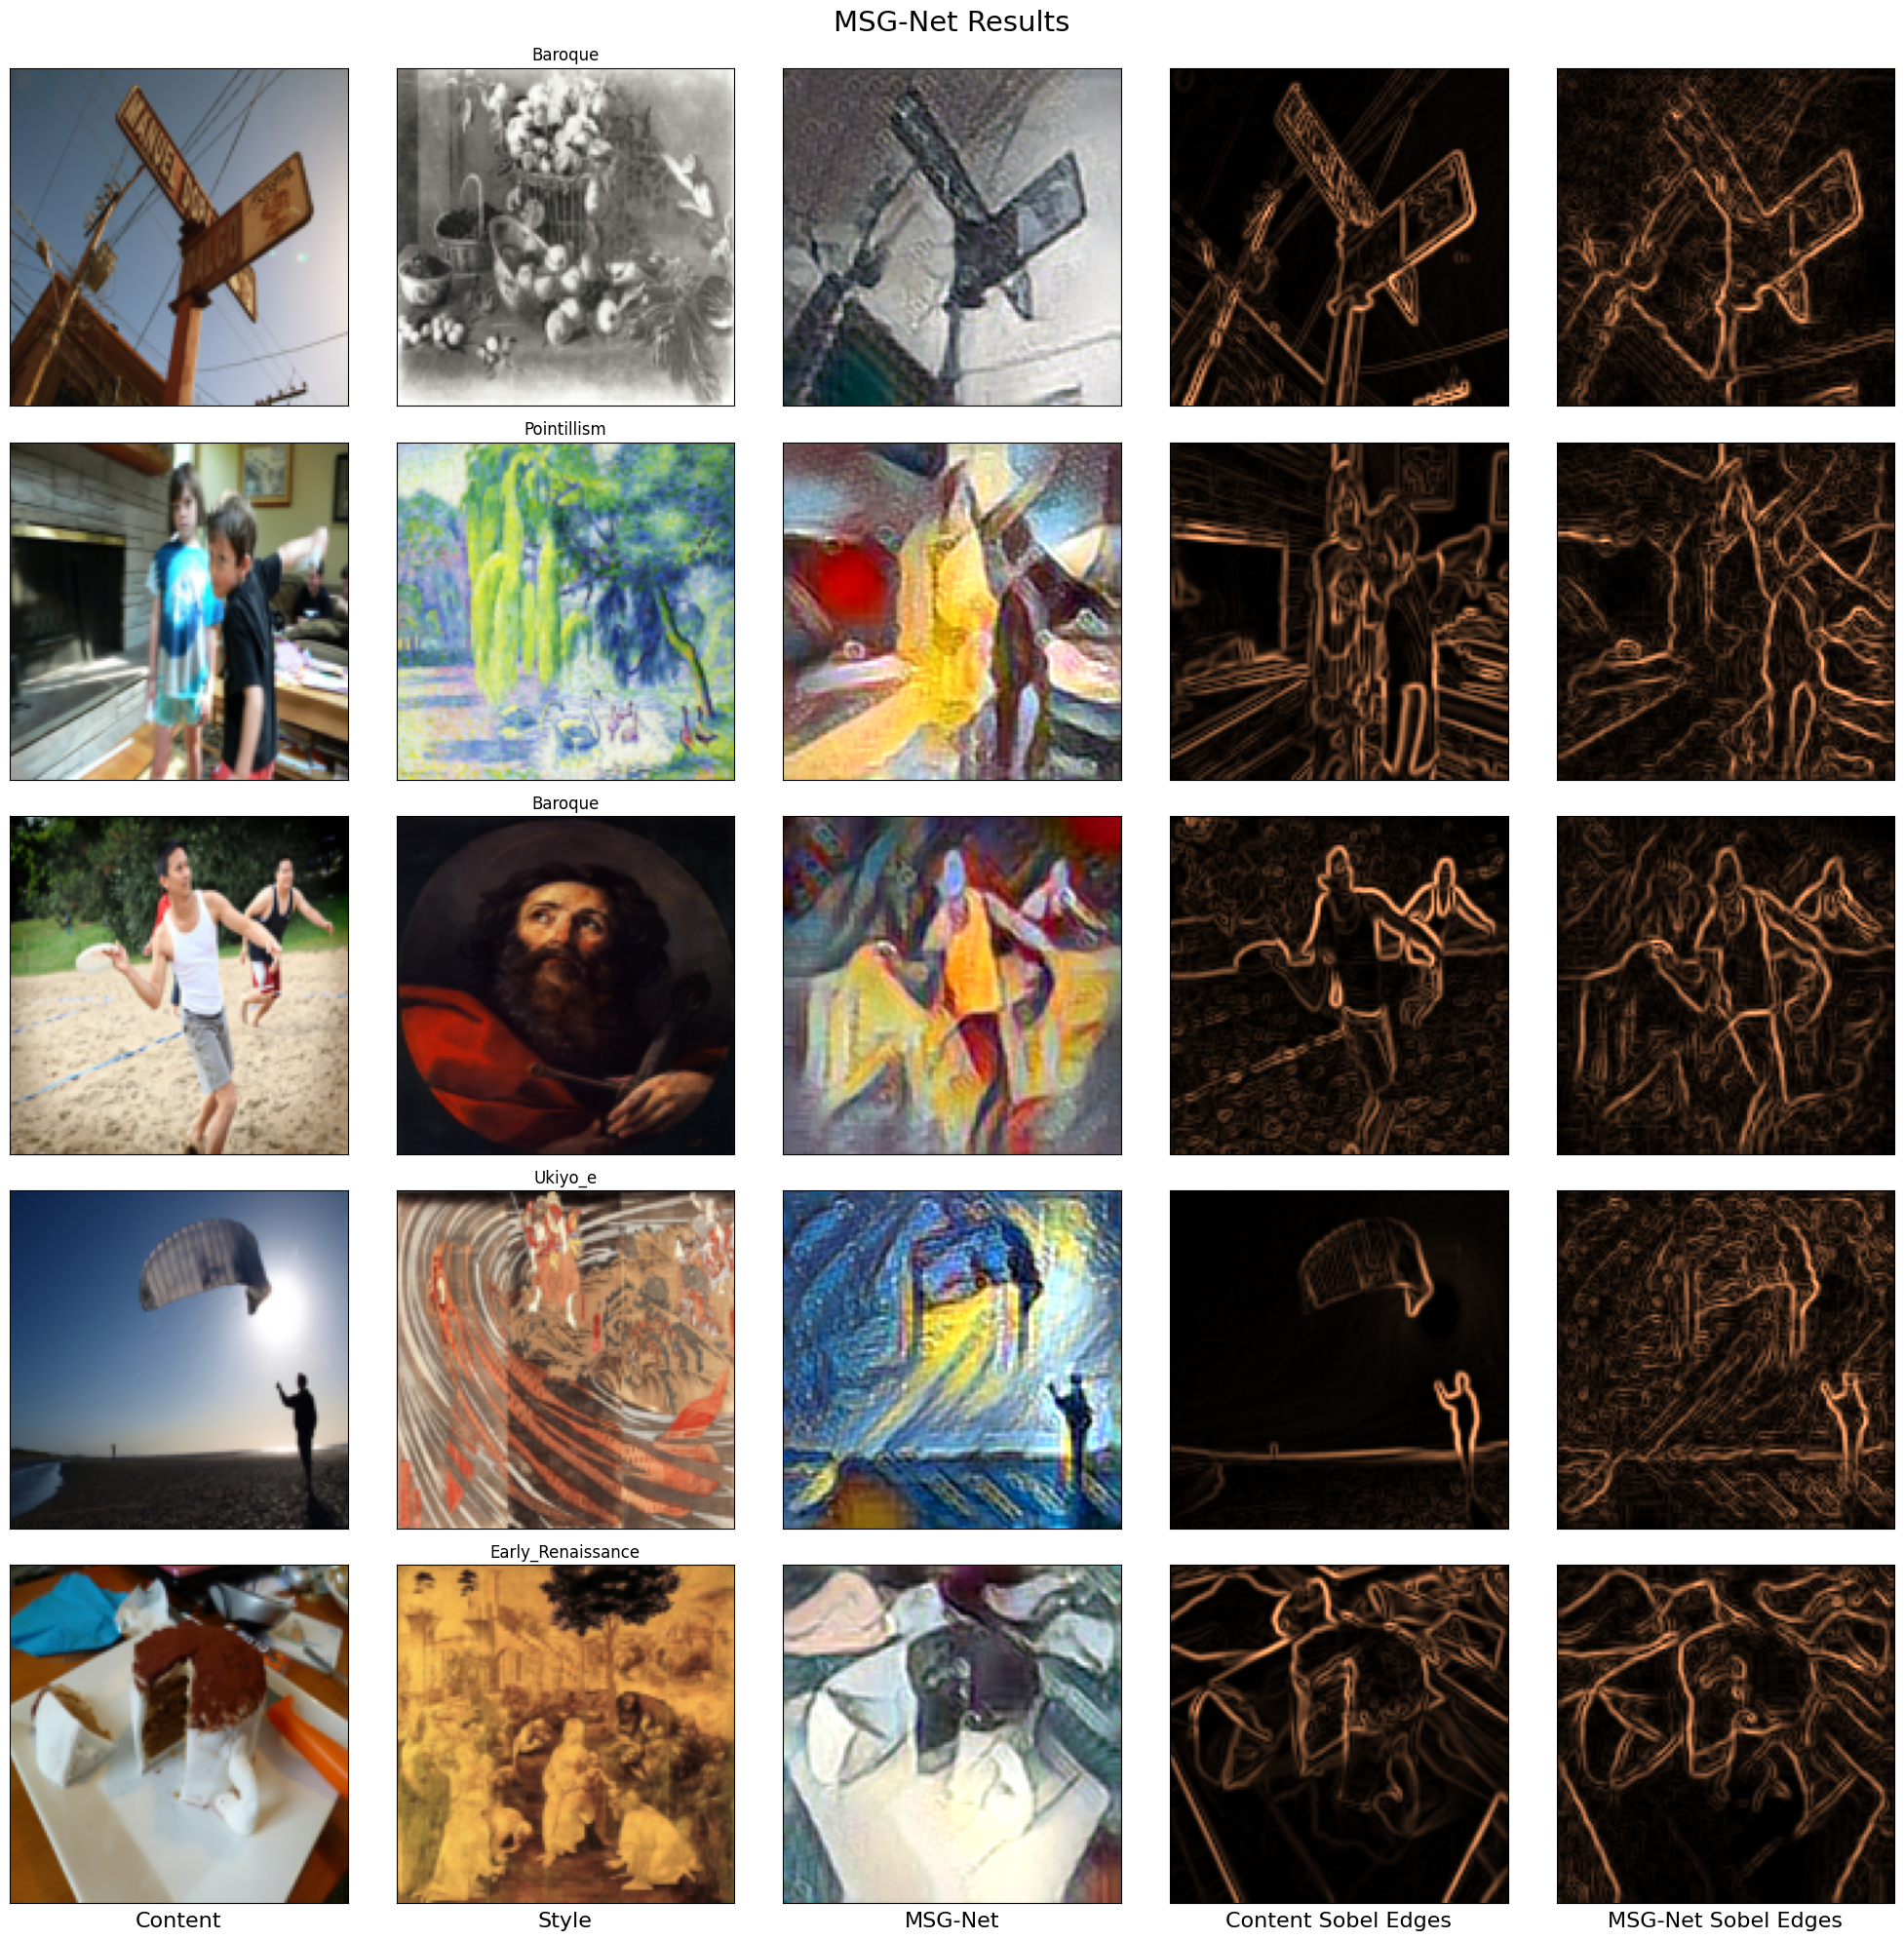

--- MSG-Net results ---
Average SSIM = 0.0000
Average FID = 32169.5052
Average content loss = 3932.7727
Average style loss = 3931.9556


In [5]:
msgnet_ssim, msgnet_fid, msgnet_content_loss, msgnet_style_loss = msgnet_eval(style_model, content_validloader, style_validloader)
print("--- MSG-Net results ---")
print(f"Average SSIM = {msgnet_ssim:.4f}")
print(f"Average FID = {msgnet_fid:.4f}")
print(f"Average content loss = {msgnet_content_loss:.4f}")
print(f"Average style loss = {msgnet_style_loss:.4f}")